# Forecasting with Linear Models on EMA Data

### 1. Importing Libraries and Reading Data

In [1]:
import pandas as pd
import numpy as np
% matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.tsa.vector_ar.vecm import coint_johansen

import load_data

# Plot settings
plt.rcParams['figure.figsize'] = (16, 8)
plt.rcParams['figure.dpi'] = 150
sns.set()

In [4]:
train_df, test_df, data_raw_list = load_data.load_alcohol()

patients_time = []
# Prepare the time series
print('Preparing the data for forecasting')
for i in range(len(data_raw_list)):
    patients_time.append(load_data.prepare_data_alcohol(data_raw_list[i]))

first_patient = patients_time[0]
first_patient.info()
first_patient.head()

Preparing the data for forecasting
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 115 entries, 2018-02-06 14:33:00 to 2018-02-22 22:18:00
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   finish            115 non-null    datetime64[ns]
 1   drinks            115 non-null    float64       
 2   comfortable       115 non-null    float64       
 3   stressed          115 non-null    float64       
 4   down              115 non-null    float64       
 5   calm              115 non-null    float64       
 6   pressure          115 non-null    float64       
 7   enthusiastic      115 non-null    float64       
 8   happy             115 non-null    float64       
 9   conflict          115 non-null    float64       
 10  craving           115 non-null    float64       
 11  impulsive         115 non-null    float64       
 12  pos_expect        115 non-null    float64       
 13  peer_per

,finish,drinks,comfortable,stressed,down,calm,pressure,enthusiastic,happy,conflict,...,impulsive,pos_expect,peer_percent,want_drink,delay_grat,angry,drink_predict,restless_sleep,difficulty_sleep,hours_sleep
start,,,,,,,,,,,,,,,,,,,,,
2018-02-06 14:33:00,2018-02-06 14:56:00,0.0,88.0,10.0,14.0,71.0,12.0,83.0,83.0,0.0,...,0.0,0.0,17.0,5.0,2.0,9.0,NaN,NaN,NaN,NaN
2018-02-06 16:20:00,2018-02-06 16:22:00,3.0,81.0,12.0,18.0,26.0,11.0,31.0,56.0,0.0,...,8.0,14.0,55.0,14.0,32.0,15.0,6.0,7.0,8.0,7.0
2018-02-06 18:54:00,2018-02-06 18:58:00,0.0,88.0,69.0,15.0,71.0,15.0,83.0,91.0,9.0,...,15.0,56.0,78.0,61.0,48.0,14.0,NaN,NaN,NaN,NaN
2018-02-06 20:08:00,2018-02-06 20:22:00,0.0,89.0,34.0,18.0,84.0,23.0,92.0,76.0,1.0,...,17.0,15.0,73.0,14.0,72.0,16.0,NaN,NaN,NaN,NaN
2018-02-06 22:29:00,2018-02-06 22:46:00,0.0,95.0,16.0,5.0,72.0,10.0,25.0,66.0,14.0,...,12.0,21.0,70.0,6.0,74.0,12.0,NaN,NaN,NaN,NaN


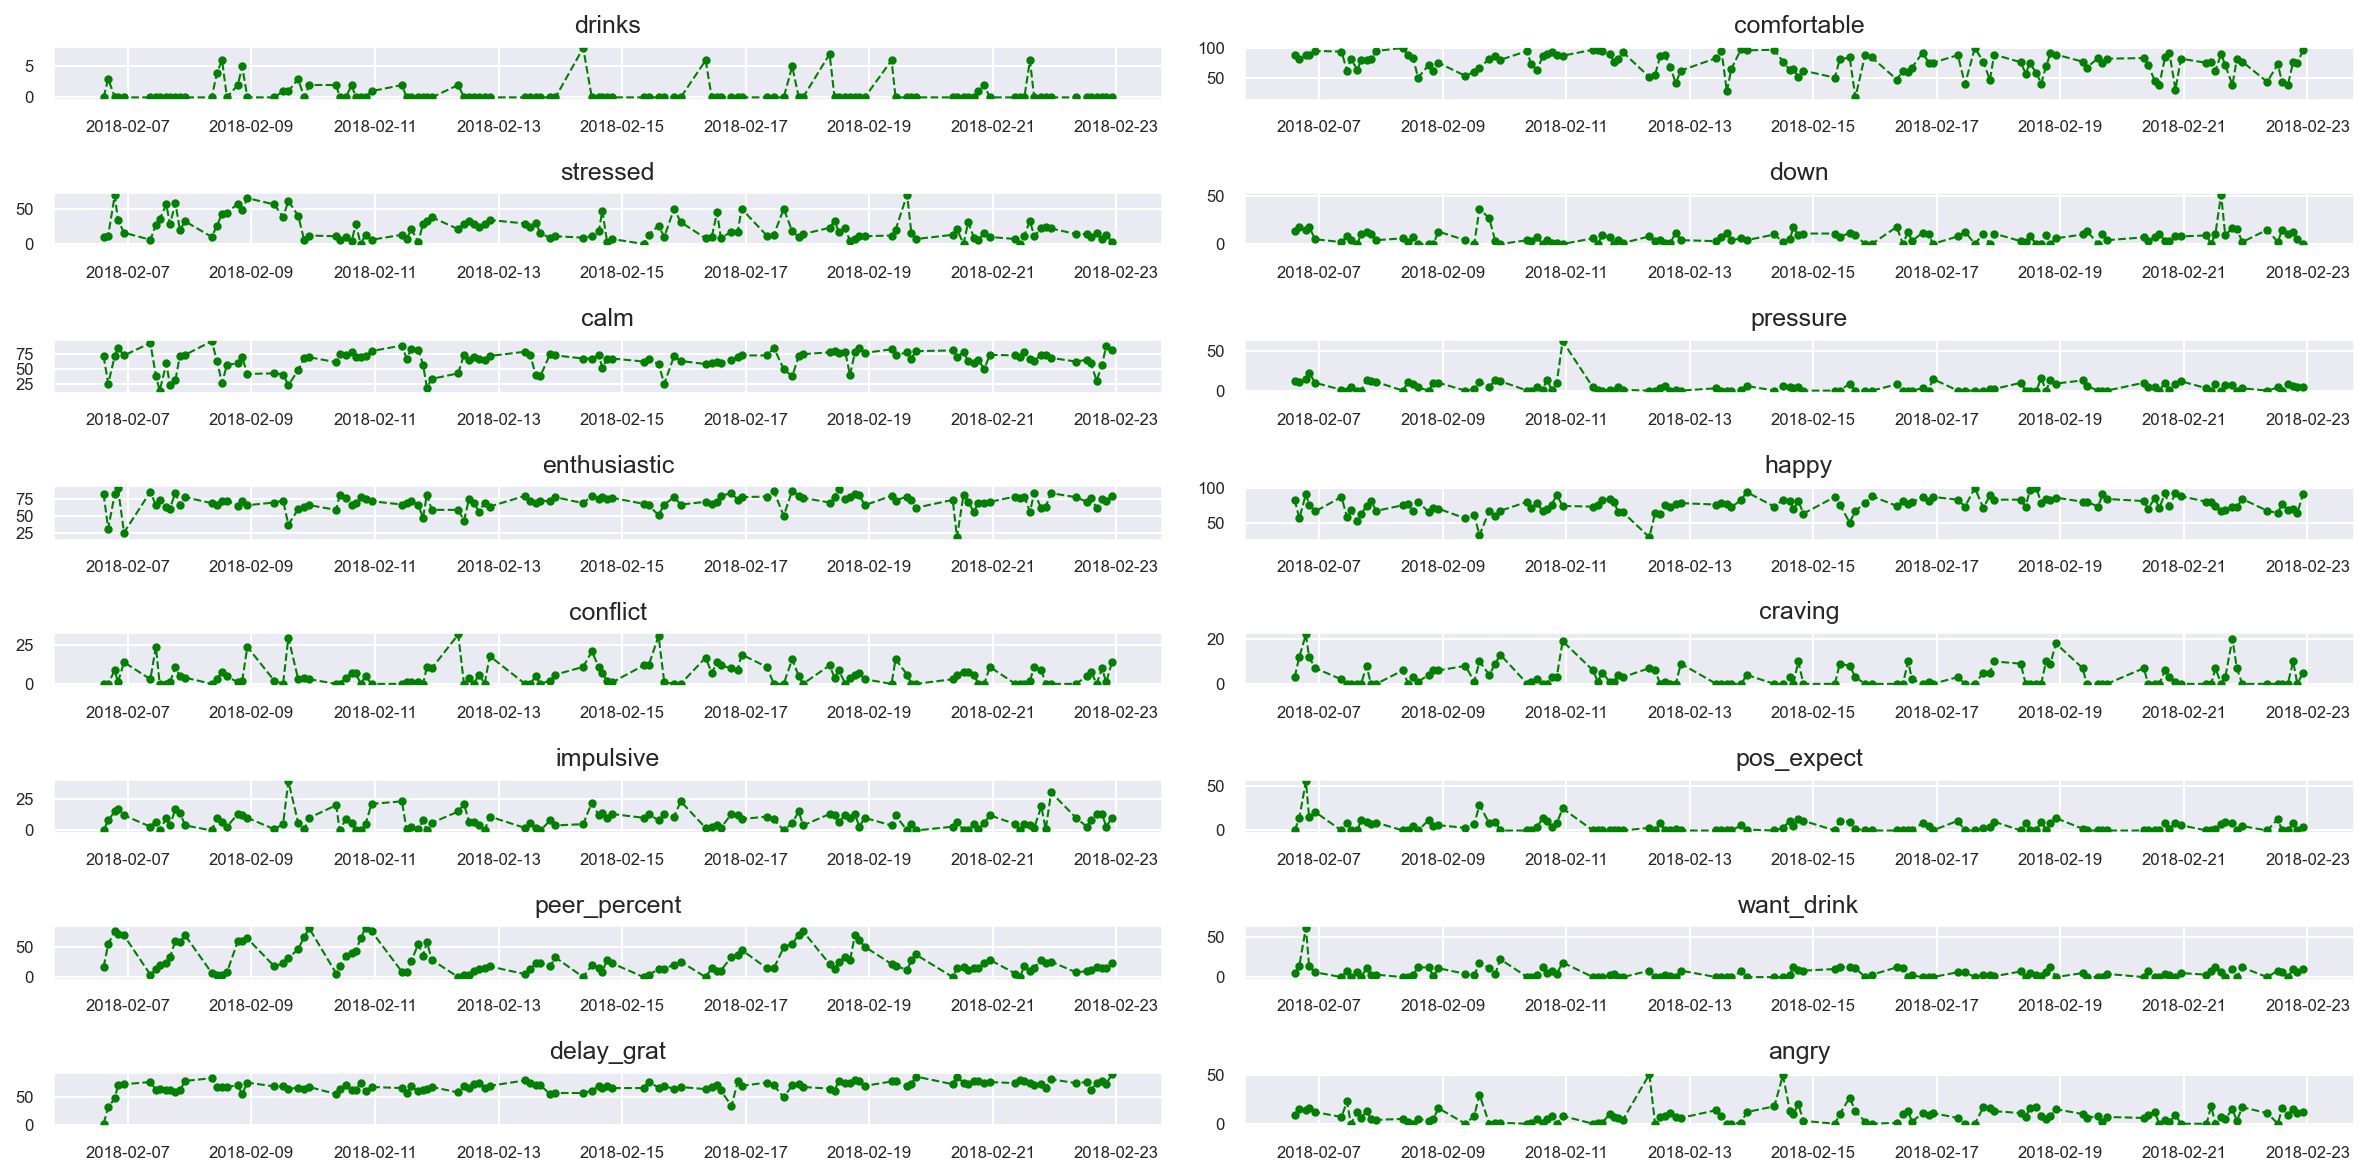

In [5]:
# Plot the data for one of the patients
fig, axes = plt.subplots(nrows=8, ncols=2)
for i, ax in enumerate(axes.flatten()):
    data = first_patient[first_patient.columns[i + 1]]
    ax.plot(data, color='green', marker='o', linestyle='dashed', linewidth=1, markersize=3)
    ax.set_title(first_patient.columns[i + 1])
    ax.tick_params(labelsize=8)
    ax.yaxis.set_ticks_position('none')

plt.tight_layout()
plt.show()

In [11]:
# ADF-Test for stationarity
#first_patient = first_patient.drop(columns=['finish' ,'drink_predict', 'restless_sleep', 'difficulty_sleep', 'hours_sleep'])

def forecast_accuracy(forecast, actual):
    print('MAPE:', np.mean(np.abs(forecast - actual) / np.abs(actual)))
    print('ME:', np.mean(forecast - actual))
    print('MAE:', np.mean(np.abs(forecast - actual)))
    print('MPE:', np.mean((forecast - actual) / actual))
    print('RMSE:', np.mean((forecast - actual) ** 2) ** .5)
    print('CORR:', np.corrcoef(forecast, actual)[0, 1])


def first_difference(data):
    return data.diff().dropna()


def is_stationary(patient_data):
    stationary = []
    for name, column in patient_data.iteritems():
        p_value = adfuller(column, autolag='AIC')[1]
        print('ADF Test for', name, ', p-value:', round(p_value, 4))
        stationary.append(p_value < 0.05)
    return all(stationary)


is_stationary(patient_data=first_patient)
# Test the model on 15 data points
df_train, df_test = first_patient[0:-15], first_patient[-15:]
df_train.head()

ADF Test for drinks , p-value: 0.0
ADF Test for comfortable , p-value: 0.0
ADF Test for stressed , p-value: 0.0007
ADF Test for down , p-value: 0.0
ADF Test for calm , p-value: 0.0
ADF Test for pressure , p-value: 0.0
ADF Test for enthusiastic , p-value: 0.0061
ADF Test for happy , p-value: 0.0001
ADF Test for conflict , p-value: 0.0
ADF Test for craving , p-value: 0.0
ADF Test for impulsive , p-value: 0.0
ADF Test for pos_expect , p-value: 0.0
ADF Test for peer_percent , p-value: 0.274
ADF Test for want_drink , p-value: 0.0
ADF Test for delay_grat , p-value: 0.0167
ADF Test for angry , p-value: 0.0


,drinks,comfortable,stressed,down,calm,pressure,enthusiastic,happy,conflict,craving,impulsive,pos_expect,peer_percent,want_drink,delay_grat,angry
start,,,,,,,,,,,,,,,,
2018-02-06 14:33:00,0.0,88.0,10.0,14.0,71.0,12.0,83.0,83.0,0.0,3.0,0.0,0.0,17.0,5.0,2.0,9.0
2018-02-06 16:20:00,3.0,81.0,12.0,18.0,26.0,11.0,31.0,56.0,0.0,12.0,8.0,14.0,55.0,14.0,32.0,15.0
2018-02-06 18:54:00,0.0,88.0,69.0,15.0,71.0,15.0,83.0,91.0,9.0,22.0,15.0,56.0,78.0,61.0,48.0,14.0
2018-02-06 20:08:00,0.0,89.0,34.0,18.0,84.0,23.0,92.0,76.0,1.0,12.0,17.0,15.0,73.0,14.0,72.0,16.0
2018-02-06 22:29:00,0.0,95.0,16.0,5.0,72.0,10.0,25.0,66.0,14.0,7.0,12.0,21.0,70.0,6.0,74.0,12.0


In [56]:
# Fit Vector Autoregression Model (VAR)
model = VAR(first_patient)
x = model.select_order(maxlags=5)
print(x.summary())

model = model.fit(5)
forecast = model.forecast(y=df_train.values[-5:], steps=df_test.shape[0])
print(forecast)
df_forecast = pd.DataFrame(forecast, index=first_patient.index[-15:])
df_forecast.columns = df_train.columns
df_forecast = df_forecast.loc[:, ['craving', 'want_drink']]
df_forecast.head()

 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0       63.91      64.31*  5.720e+27*      64.07*
1       64.83       71.51   1.491e+28       67.54
2       66.26       79.22   8.117e+28       71.52
3       66.77       86.01   2.902e+29       74.57
4       66.01       91.54   7.784e+29       76.36
5      60.79*       92.61   1.851e+29       73.70
-------------------------------------------------
[[ 1.11681420e+00  6.60725788e+01  1.28112569e+01  1.06637256e+01
   7.80918226e+01  3.18888738e+00  7.64069643e+01  8.29889934e+01
   2.86684860e+00  4.33786155e-01  1.11444673e+01  2.32397683e-01
   4.88223440e+00  7.31849732e+00  7.17513984e+01  4.24165312e+00]
 [ 4.14782996e-01  7.76843670e+01 -5.97954432e-01  3.78941972e+00
   6.97855852e+01  1.18885026e+00  7.62936064e+01  8.08923643e+01
  -3.21043961e+00  6.60618298e-01 -6.83075044e+00  5.66383720e-01
   5.53165420e+00  2.58864993e+00  7.

C:\Users\Alex\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


,craving,want_drink
start,,
2018-02-21 08:46:00,0.433786,7.318497
2018-02-21 10:34:00,0.660618,2.588650
2018-02-21 12:15:00,3.233723,12.182825
2018-02-21 14:26:00,0.593383,1.898941
2018-02-21 16:04:00,5.132176,4.768713


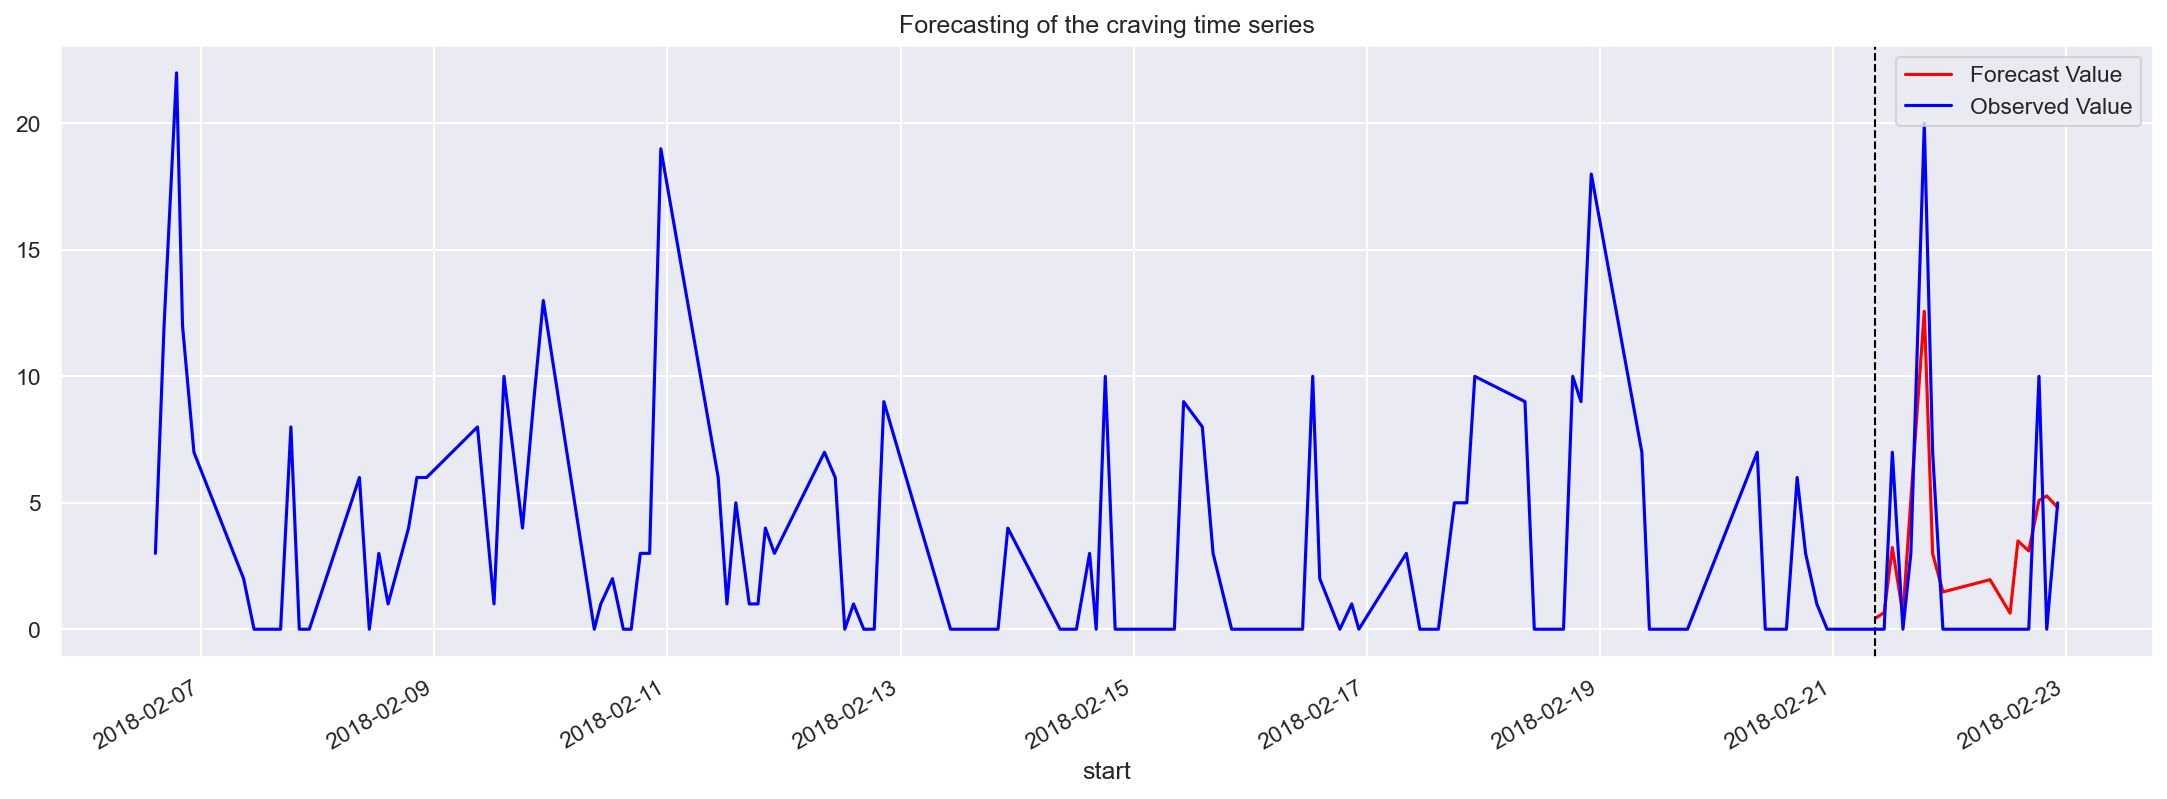

In [61]:
fig, ax = plt.subplots(figsize=(18, 6))
ax.plot(df_test.index, df_forecast['craving'], color='red', label='Forecast Value')

plt.axvline(df_test.index[0], c='black', ls='--', lw=1)
first_patient.plot(y='craving', color='blue', ax=ax, label='Observed Value')

plt.legend(loc='upper right')
plt.title('Forecasting of the craving time series')

plt.show()

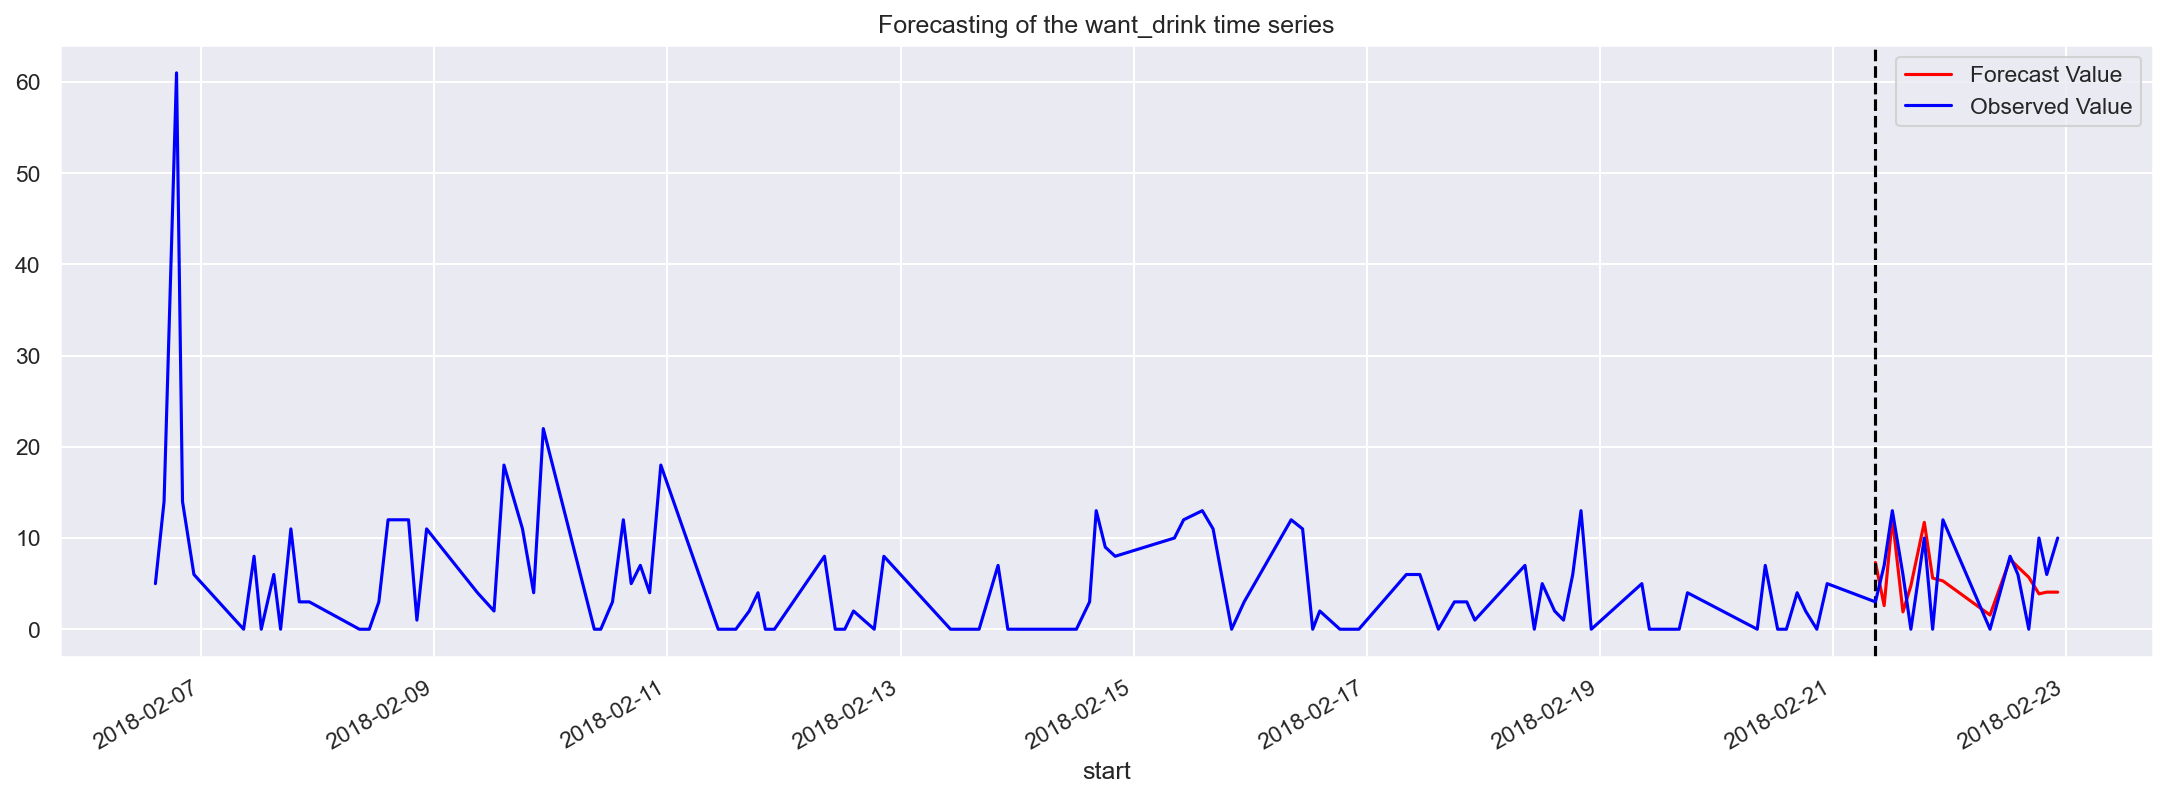

In [62]:
fig, ax = plt.subplots(figsize=(18, 6))
ax.plot(df_test.index, df_forecast['want_drink'], color='red', label='Forecast Value')

plt.axvline(df_test.index[0], c='black', ls='--')
first_patient.plot(y='want_drink', color='blue', ax=ax, label='Observed Value')

plt.legend(loc='upper right')
plt.title('Forecasting of the want_drink time series')

plt.show()